In [1]:
import numpy as np
from scipy import stats
import torchvision
import torch
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch.utils.data import DataLoader
import multiprocessing
from tqdm import tqdm

MEAN, STD = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)

In [51]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(MEAN, STD)  
    ])

In [52]:
train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


## Finetune on cifar10 to get representation

In [79]:
resnet18 = torchvision.models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)

/home/viet/anaconda3/envs/dl/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/viet/anaconda3/envs/dl/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [54]:
batch_size = 64
learning_rate=5e-5
epochs = 100

In [59]:
trainloader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=multiprocessing.cpu_count())
testloader = DataLoader(test, batch_size=batch_size, shuffle=True, num_workers=multiprocessing.cpu_count())

In [60]:
optimizer = optim.AdamW(resnet18.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [62]:
patience = 0
best = 0
for epoch in range(epochs):
    model.train()
    for batch_idx, (imgs, labels) in enumerate(tqdm(trainloader)):
        imgs, labels = imgs.cuda(), labels.cuda()
        output = model(imgs)
        optimizer.zero_grad()
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
    
    model.eval()
    count = 0
    acc = 0 
    with torch.no_grad():
        for imgs, labels in tqdm(testloader):
            imgs, labels = imgs.cuda(), labels.cuda()
            output = model(imgs)
            preds = torch.argmax(output, 1)
            acc += torch.sum(preds == labels)
            count += len(labels)
    acc = (acc/count).item()
    if acc > best:
        best = acc
        patience = 0
    else:
        patience += 1
    print(acc)
    if patience > 5:
        print(best)
        break

 48%|████▊     | 375/782 [00:02<00:02, 141.49it/s]


KeyboardInterrupt: 

In [ ]:
rep = torch.nn.Sequential(*list(model.children())[:-1])

In [ ]:
rep

In [ ]:
torch.save(rep.state_dict(), 'resnet18_cifar10.pth')

In [84]:
def get_rep(model, dataset):
    model = model.cuda()
    model.eval()
    new_data = np.zeros((len(dataset), 512))
    i = 0
    for features, label in tqdm(dataset):
        features = features.unsqueeze(0).cuda()
        rep = model(features)
        rep = torch.flatten(rep)
        new_data[i] = rep.cpu().detach().numpy()
        i += 1
    return new_data

In [ ]:
x = get_rep(rep, train)

In [ ]:
x_ = get_rep(rep, test)

In [ ]:
with open('data/cifar10_x_train.npy', 'wb') as f:
    np.save(f, x)
with open('data/cifar10_x_test.npy', 'wb') as f:
    np.save(f, x_)
with open('data/cifar10_y_train.npy', 'wb') as f:
    np.save(f, np.array(train.targets))
with open('data/cifar10_y_test.npy', 'wb') as f:
    np.save(f, np.array(test.targets))

## CIFAR-10.1

In [92]:
# load representation
model = torchvision.models.resnet18()
model = torch.nn.Sequential(*list(model.children())[:-1])
model.load_state_dict(torch.load('resnet18_cifar10.pth'))
model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [93]:
with open('data/cifar10.1_v6_data.npy', 'rb') as f:
    cifar101_x_test = np.load(f)
with open('data/cifar10.1_v6_labels.npy', 'rb') as f:
    cifar101_y_test = np.load(f)
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(MEAN, STD)  
    ])

In [94]:
from torch.utils.data import Dataset, DataLoader
class Cifar101(Dataset):
    def __init__(self, images, labels, transform=None):
        self.data = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.data[idx]
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]
    

In [95]:
dataset = Cifar101(cifar101_x_test, cifar101_y_test, transform=transform)

In [99]:
cifar101_512 = get_rep(model, dataset)

100%|██████████| 2000/2000 [00:01<00:00, 1047.07it/s]


In [101]:
with open('data/cifar101_x_test.npy', 'wb') as f:
    np.save(f, cifar101_512)

### Load cifars

In [104]:
def load_cifar10_512():
    with open('data/cifar10_x_train.npy', 'rb') as f:
        x_train = np.load(f)
    with open('data/cifar10_x_test.npy', 'rb') as f:
        x_test = np.load(f)
    with open('data/cifar10_y_train.npy', 'rb') as f:
        y_train = np.load(f)
    with open('data/cifar10_y_test.npy', 'rb') as f:
        y_test = np.load(f)
    return x_train, x_test, y_train, y_test

In [105]:
def load_cifar101_512():
    with open('data/cifar101_x_test.npy', 'rb') as f:
        x_test = np.load(f)
    with open('data/cifar10.1_v6_labels.npy', 'rb') as f:
        y_test = np.load(f)
    return x_test, y_test

In [114]:
x_train, x_val, y_train, y_val = load_cifar10_512()
x_test, y_test = load_cifar101_512()

(2000,)

### Shuffle data

In [167]:
xy_test = np.concatenate([x_test, np.expand_dims(y_test, axis=1)], axis=1)
np.random.shuffle(xy_test)
x_test, y_test = xy_test[:, :512], xy_test[:,512:]

In [168]:
x_test.shape, y_test.shape

((2000, 512), (2000, 1))

## H-Divergence

In [169]:
class H_Divergence:
    '''
    Given two datasets, fit 3 gaussians, 2 on the datasets and 1 on the joint.
    Then, compute the statistic: 
    l((P+Q)/2) - min(l(P), l(Q))
    Use this test statistic as the computed value in the permutation test
    '''
    def __init__(self, bandwidth='scott'):
        self.bandwidth = bandwidth
        
    def _get_kde_estimates(self, bandwidth, data) :
        # kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
        data = data.T
        kernel = stats.gaussian_kde(data, bandwidth)
        return kernel.evaluate(data)
    
    def get_distance(self, X, Y):
        if len(X) > len(Y):
            idx = np.random.choice(len(X), len(Y), replace=False)
            X = X[idx]
        XY = np.concatenate([X, Y], axis=0)
        logprob_1 = self._get_kde_estimates(self.bandwidth, X)
        logprob_2 = self._get_kde_estimates(self.bandwidth, Y)
        logprob_m = self._get_kde_estimates(self.bandwidth, XY)
        
        vdiv = np.mean(-logprob_m) - min(np.mean(-logprob_1), np.mean(-logprob_2))
        
        return vdiv

In [170]:
import time
def permutation_test(distance, P, Q, X, Y, perms=500, oracle=False, alpha=0.05, enable_tqdm=False, subsample_size=1000):
    """Performs a permutation test

    Args:
        distance : Computes an empirical distance between two distributions given samples
        P: full access to P
        Q: full access to Q
        X (_type_): original sample, Xi ~ P
        Y (_type_): original sample, Yi ~ Q
        perms (int): number of permutations to run
        oracle (bool, optional): Whether access to the full distribution is granted.
        alpha (float, optional): significance level, defaults to 0.05 
    """
    est = distance.get_distance(X, Y)
    print(est)
    XuY = np.concatenate([X, Y], axis=0)
    distr = []
    f = tqdm if enable_tqdm else lambda x: x 
    
    for i in f(range(perms)):
        
        if oracle:
            XuY = np.concatenate([P.sample(n=len(X)), Q.sample(n=len(Y))], axis=0)
        np.random.shuffle(XuY)
        idx = np.random.choice(len(XuY), len(Y))
        X_, Y_ = XuY[idx[:len(Y)//2]], XuY[idx[len(Y)//2:]]
        start = time.time()
        tmp = distance.get_distance(X_, Y_)
        distr.append(tmp)
        end = time.time()
        
        #print('Time elapsed: {}'.format(end - start ))
        
    q = np.quantile(distr, 1-alpha)
    return int(est > q), distr, est

#### PCA

In [171]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(x_train)
x_train_pca, x_val_pca = pca.transform(x_train), pca.transform(x_val)
x_test_pca = pca.transform(x_test)

In [174]:
hdiv = H_Divergence()
hdiv.get_distance(x_train_pca[:], x_test_pca[:])

7.407741279819527e-14

In [184]:
flag, distr, est = permutation_test(hdiv, P=None, Q=None, X=x_train_pca, Y=x_test_pca[:500], perms=100, enable_tqdm=True, subsample_size=1000)

7.75651074368367e-14


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:03<00:00, 30.80it/s]


1


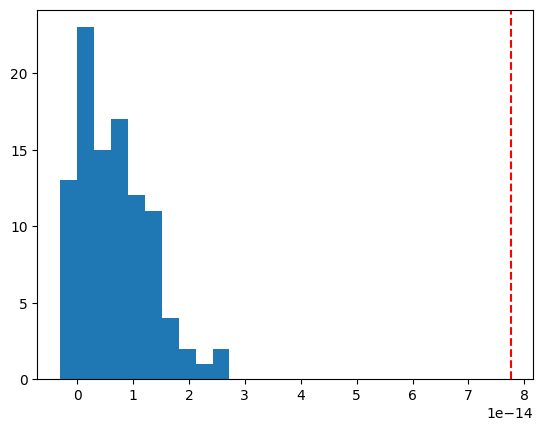

In [185]:
import matplotlib.pyplot as plt
plt.hist(distr)
plt.axvline(x=est, color='r', linestyle='--')
print(flag)

In [2]:
class KL_Divergence:
    '''
    Given two datasets, fit 2 gaussians on each of them.
    Then, compute the kl-divergence between them depending on the mode.
    '''
    def __init__(self, bandwidth):
        self.bandwidth = bandwidth
    
    def get_distance(self, X, Y):
        X, Y = X.T, Y.T
        kernel_X = stats.gaussian_kde(X, self.bandwidth)
        kernel_Y = stats.gaussian_kde(Y, self.bandwidth)
        prob_p = kernel_X.evaluate(X)
        logprob_p = kernel_X.logpdf(X)
        logprob_q = kernel_Y.logpdf(X)
        
        kl = np.mean(np.multiply(prob_p, logprob_p - logprob_q))
        
        return kl